In [1]:
import pandas as pd
import nltk
import unicodedata
import re
from gensim import corpora
from gensim.models import LdaModel
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
import string
from gensim.models import CoherenceModel
import matplotlib.pyplot as plt

In [2]:
# to print out all the outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
# Load DataFrame
df = pd.read_csv("../data/pdf_metadata_and_summaries_trf.csv")  # Replace with your actual filename

In [4]:
df.columns

Index(['File Name', 'Metadata', 'Summary'], dtype='object')

In [5]:
ADDITIONAL_STOPWORDS = ['bank', 'fdic', 'institution', 'percent', 'million', 'nthe']

# Function to clean the sentence and return a list of cleaned words
def clean(sentence):
    wnl = nltk.stem.WordNetLemmatizer()
    stopwords_list = stopwords.words('english') + ADDITIONAL_STOPWORDS
    sentence = (unicodedata.normalize('NFKD', sentence)
                .encode('ascii', 'ignore')
                .decode('utf-8', 'ignore')
                .lower())
    
    # Remove numbers, punctuations, and any word with a single letter
    sentence = re.sub(r'[^a-zA-Z\s]', '', sentence)  # Keep only alphabetic characters and spaces
    words = sentence.split()
    
    # Lemmatize and filter out stopwords and single-letter words
    word_list = [wnl.lemmatize(word) for word in words if len(word) > 1 and word not in stopwords_list]
    
    return word_list

# Function to get a list of lists of cleaned words from a dataframe column
def get_words(df, column):
    """
    Takes a dataframe and a column and returns a list of
    lists of cleaned words that are returned by clean().

            Parameters:
                    df (dataframe): A pandas dataframe
                    column (str): A column name in the dataframe

            Returns:
                    list of lists: A list where each element is a list of cleaned words for each document
    """
    # Apply clean() to each row in the specified column
    return [clean(str(text)) for text in df[column]]

In [6]:
all_words = get_words(df, 'Summary')

In [7]:
type(all_words)

list

In [8]:
len(all_words)

98

In [9]:
all_words[0]

['february',
 'report',
 'aud',
 'material',
 'loss',
 'review',
 'first',
 'priority',
 'bradenton',
 'florida',
 'audit',
 'report',
 'report',
 'aud',
 'february',
 'material',
 'loss',
 'review',
 'first',
 'priority',
 'bradenton',
 'florida',
 'audit',
 'result',
 'fpb',
 'failed',
 'primarily',
 'due',
 'management',
 'aggressive',
 'pursuit',
 'asset',
 'growth',
 'concentrated',
 'highrisk',
 'cre',
 'loan',
 'inadequate',
 'loan',
 'underwriting',
 'lack',
 'loan',
 'portfolio',
 'risk',
 'management',
 'control',
 'resulting',
 'loss',
 'severely',
 'eroded',
 'fpbs',
 'earnings',
 'capital',
 'negatively',
 'impacted',
 'liquidity',
 'leading',
 'bank',
 'failure',
 'material',
 'loss',
 'dif',
 'management',
 'fpbs',
 'board',
 'director',
 'bod',
 'ensure',
 'management',
 'identified',
 'measured',
 'monitored',
 'controlled',
 'risk',
 'institution',
 'activity',
 'addition',
 'bod',
 'ensure',
 'corrective',
 'action',
 'implemented',
 'response',
 'examiner',
 'audito

In [10]:
# Create a dictionary from the tokenized texts
dictionary = corpora.Dictionary(all_words)

# Create a corpus: a list of bag-of-words for each document
corpus = [dictionary.doc2bow(word) for word in all_words]

In [20]:
# Apply LDA model
lda_model = LdaModel(corpus, num_topics=4, id2word=dictionary, passes=15)

# Print the topics
topics = lda_model.print_topics(num_words=7)  # num_words shows top words in each topic
for topic in topics:
    print(topic)

(0, '0.016*"loan" + 0.012*"examination" + 0.011*"capital" + 0.011*"bank" + 0.011*"management" + 0.011*"report" + 0.010*"risk"')
(1, '0.024*"loan" + 0.014*"management" + 0.012*"examination" + 0.011*"risk" + 0.010*"bank" + 0.009*"examiner" + 0.008*"capital"')
(2, '0.021*"loan" + 0.014*"examination" + 0.013*"bank" + 0.013*"management" + 0.012*"risk" + 0.012*"report" + 0.011*"capital"')
(3, '0.013*"management" + 0.012*"loan" + 0.011*"examination" + 0.011*"risk" + 0.009*"report" + 0.009*"review" + 0.008*"institution"')


In [23]:
def compute_coherence_values(dictionary, corpus, texts, start=2, limit=10, step=1):
    """
    Compute coherence scores for different numbers of topics.

    Parameters:
        dictionary (gensim.corpora.Dictionary): Gensim dictionary.
        corpus (list): Gensim corpus.
        texts (list of list of str): Tokenized texts.
        start (int): Minimum number of topics.
        limit (int): Maximum number of topics.
        step (int): Step size for topics.

    Returns:
        model_list (list): List of LDA topic models.
        coherence_values (list): Coherence values corresponding to the LDA models.
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=493)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

Text(0.5, 0, 'Number of Topics')

Text(0, 0.5, 'Coherence Score')

Text(0.5, 1.0, 'Coherence Score vs Number of Topics')

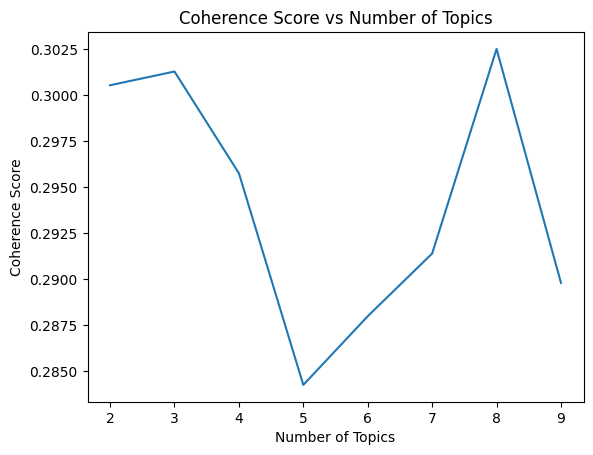

In [24]:
# Compute coherence values
model_list, coherence_values = compute_coherence_values(dictionary, corpus, all_words, start=2, limit=10, step=1)

# Plot coherence values
x = range(2, 10, 1)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Score vs Number of Topics")
plt.show()

In [14]:
for num_topics in range(2, 10, 1):
    model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=10, random_state=493)
    print(f"Num Topics: {num_topics}, Perplexity: {model.log_perplexity(corpus)}")


Num Topics: 2, Perplexity: -6.972171178649991
Num Topics: 3, Perplexity: -6.9588728385638365
Num Topics: 4, Perplexity: -6.9570531249544665
Num Topics: 5, Perplexity: -6.950411265295697
Num Topics: 6, Perplexity: -6.945673991371278
Num Topics: 7, Perplexity: -6.934889871106576
Num Topics: 8, Perplexity: -6.936405864307275
Num Topics: 9, Perplexity: -6.934640514967947


In [21]:
import pyLDAvis
import pyLDAvis.gensim_models
from IPython.display import display

# Display visualization inline in Jupyter Notebook
pyLDAvis.enable_notebook()
lda_display = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary, sort_topics=False)
display(lda_display)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.022891  0.043825       1        1  22.025011
1     -0.017563 -0.037578       2        1  24.259451
2     -0.021527 -0.008747       3        1  46.252527
3      0.061981  0.002500       4        1   7.463011, topic_info=                   Term          Freq         Total Category  logprob  loglift
749          management   8889.000000   8889.000000  Default  30.0000  30.0000
1076             review   3854.000000   3854.000000  Default  29.0000  29.0000
1082               risk   7856.000000   7856.000000  Default  28.0000  28.0000
988              rating   2535.000000   2535.000000  Default  27.0000  27.0000
726                loan  14023.000000  14023.000000  Default  26.0000  26.0000
451         examination   9183.000000   9183.000000  Default  25.0000  25.0000
661         institution   5598.000000   5598.000000  Default  24.0000  24.0000
99                asset   5477.000000   5477.000000  Default  23.0000  23.0000
1041             report   7265.000000   7265.000000  Default  22.0000  22.0000
340             deposit   4500.000000   4500.000000  Default  21.0000  21.0000
516               first   1654.000000   1654.000000  Default  20.0000  20.0000
732                loss   5514.000000   5514.000000  Default  19.0000  19.0000
1209        supervisory   4205.000000   4205.000000  Default  18.0000  18.0000
675          investment    735.000000    735.000000  Default  17.0000  17.0000
160             capital   6976.000000   6976.000000  Default  16.0000  16.0000
723           liquidity   2288.000000   2288.000000  Default  15.0000  15.0000
452            examiner   5202.000000   5202.000000  Default  14.0000  14.0000
1085                roe   1094.000000   1094.000000  Default  13.0000  13.0000
143               board   3180.000000   3180.000000  Default  12.0000  12.0000
235       concentration   4453.000000   4453.000000  Default  11.0000  11.0000
513           financial   4706.000000   4706.000000  Default  10.0000  10.0000
6866           republic    497.000000    497.000000  Default   9.0000   9.0000
498                fdic   2407.000000   2407.000000  Default   8.0000   8.0000
1107           security   1177.000000   1177.000000  Default   7.0000   7.0000
144                 bod    574.000000    574.000000  Default   6.0000   6.0000
21               action   4057.000000   4057.000000  Default   5.0000   5.0000
6067           affinity    229.000000    229.000000  Default   4.0000   4.0000
7354             puerto    395.000000    395.000000  Default   3.0000   3.0000
6029                fsb    532.000000    532.000000  Default   2.0000   2.0000
762            material   2867.000000   2867.000000  Default   1.0000   1.0000
7365               rico    386.892731    388.519818   Topic1  -5.9924   1.5088
7354             puerto    393.613369    395.328676   Topic1  -5.9752   1.5086
8280             seaway    264.753101    266.124706   Topic1  -6.3717   1.5078
8150              doral    150.629887    151.502398   Topic1  -6.9357   1.5072
8151             dorals    129.294238    130.131853   Topic1  -7.0884   1.5065
7363                 rg    210.298037    211.745886   Topic1  -6.6020   1.5061
8282                sla    164.868759    166.081829   Topic1  -6.8454   1.5057
7078            advanta    124.312275    125.281211   Topic1  -7.1277   1.5052
7389        westernbank    121.402543    122.363690   Topic1  -7.1514   1.5051
7633          shorebank    176.340941    177.740854   Topic1  -6.7781   1.5051
6591       madisonville    133.835190    134.988025   Topic1  -7.0539   1.5044
7634         shorebanks    127.081029    128.193209   Topic1  -7.1057   1.5043
8063                vbi     97.113866     98.081026   Topic1  -7.3746   1.5031
7318           eurobank    113.462584    114.599257   Topic1  -7.2190   1.5030
8328                nbc    104.782616    105.848317   Topic1  -7.2986   1.5029

<Figure size 800x500 with 0 Axes>

Text(0.5, 0, 'Number of Clusters (Topics)')

Text(0, 0.5, 'Silhouette Score')

Text(0.5, 1.0, 'Optimal Number of Topics Using K-means and Silhouette Scores')

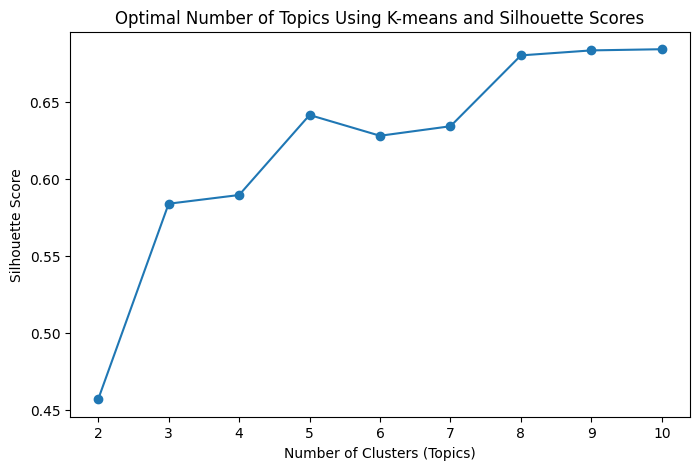

In [25]:
from gensim.models import LdaModel
from gensim import corpora
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

# Each document is represented as a vector of topic probabilities
doc_topic_matrix = np.array([dict(lda_model.get_document_topics(bow, minimum_probability=0)) 
                              for bow in corpus])

# Ensure a dense matrix with all probabilities for each topic
doc_topic_matrix = np.array([[doc.get(i, 0.0) for i in range(lda_model.num_topics)] for doc in doc_topic_matrix])

# Step 4: Apply K-means Clustering
def optimal_kmeans(doc_topic_matrix, max_clusters=10):
    silhouette_scores = []
    cluster_range = range(2, max_clusters + 1)
    
    for k in cluster_range:
        kmeans = KMeans(n_clusters=k, random_state=42)
        cluster_labels = kmeans.fit_predict(doc_topic_matrix)
        silhouette_avg = silhouette_score(doc_topic_matrix, cluster_labels)
        silhouette_scores.append(silhouette_avg)
    
    return cluster_range, silhouette_scores

cluster_range, silhouette_scores = optimal_kmeans(doc_topic_matrix, max_clusters=10)

# Step 5: Plot the Results
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel("Number of Clusters (Topics)")
plt.ylabel("Silhouette Score")
plt.title("Optimal Number of Topics Using K-means and Silhouette Scores")
plt.show()